Danny Abraham
<center><h1>CMPS 351</h1></center>
<center><h2>Assignment 4</h2></center>

In [2]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt

## Cross-well Tomography
---

In [3]:
# loading the data files
d = np.load('d.npy')
G = np.load('G.npy')

In [12]:
# determining the condition number
la.cond(G)


3.8036760564512097e+18

We see here that the condition number of the coefficient matrix is very very large. 

#### Linear Least Squares Problem
<img src='linearleastsquares.PNG'>

$G.T\dot G$ Has a very large condition number, this formulation cannot be solved, too many digits of accuracy will be lost
#### Regularized Linear Least Squares Problem
<img src='regularized.PNG'>

#### Solving for Several Values of Alpha

In [33]:
alphas = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e+1, 1e+2, 1e+3, 1e+4, 1e+5]
x = []
for alpha in alphas:
    x.append( la.solve(G.T@G + alpha*np.identity(256), G.T@d) )

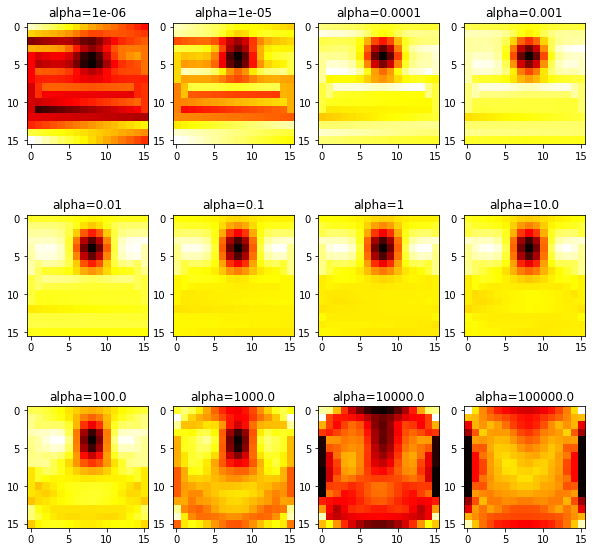

In [34]:
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(10)
for i in range(12):
    ax = fig.add_subplot(3, 4, i + 1)
    ax.imshow(x[i].reshape(16, 16), cmap='hot')
    ax = plt.title('alpha=' + str(alphas[i]))

alpha = 0.1 or alpha = 1 appear to be the ideal values for the regularization

#### Solving with Singular Value Decomposition

In [35]:
U, S, V = np.linalg.svd(G)

In [36]:
xstar = ((U.T[0]@d)/S[0])*V[0]
for i in range(1, 256):
    if (S[i] >= 2):
        xstar += ((U.T[i]@d)/S[i])*V[i]

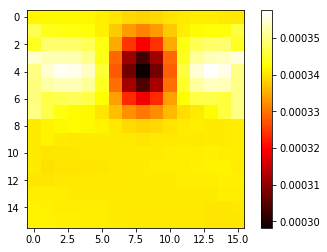

In [37]:
plt.imshow(xstar.reshape(16, 16), cmap='hot')
plt.colorbar()
plt.show()

## Systems of Nonlinear Equations
---
#### System of Nonlinear Equations f

In [38]:
def fun(x):
    f = np.zeros(2)
    f[0] = (2*x[0] + x[1]) / ((1 + (x[0] + x[1])**2)**0.5)
    f[1] = (2*x[0] - x[1]) / ((1 + (x[0] - x[1])**2)**0.5)
    return f

#### Jacobian

In [39]:
def fun_jacobian(x):
    j = np.array([np.zeros(2), np.zeros(2)])
    j[0, 0] = 2 / ( (1 + (2*x[0] + x[1])**2)**1.5 )
    j[0, 1] = 1 / ( (1 + (2*x[0] + x[1])**2)**1.5 )
    j[1, 0] = 2 / ( (1 + (2*x[0] - x[1])**2)**1.5 )
    j[1, 1] = -1 / ( (1 + (2*x[0] - x[1])**2)**1.5 )
    return j

#### Basic Newton

In [40]:
def newton_method(f, jacobian, x0, tol = 1e-6):
    x = x0
    history = np.array([la.norm(f(x))])
    while (la.norm(f(x)) >= tol):
        del_x = la.solve(jacobian(x), -f(x))
        x += del_x
        history = np.append(history, [la.norm(f(x))])
    return x, history

#### Plotting the Performance

In [41]:
x0 = np.array([0.29, 0.29])
xstar, history = newton_method(fun, fun_jacobian, x0)

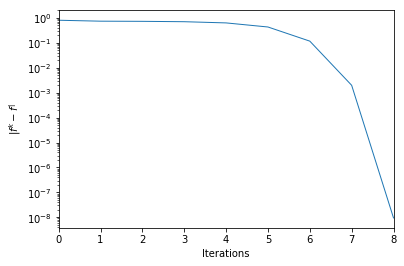

In [42]:
nsteps = history.shape[0]
    
plt.figure()
plt.autoscale(enable=True, axis='x', tight=True)
plt.semilogy(np.arange(0, nsteps), history, linewidth=1)
plt.xlabel('Iterations')
plt.ylabel(r'$|f^k - f^|$')
plt.show()

#### Divergent Behavior

In [43]:
x0 = np.array([0.5, 0.5])
xstar, history = newton_method(fun, fun_jacobian, x0)

C:\Users\Danny\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Danny\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in double_scalars
  after removing the cwd from sys.path.


#### Merit Function

In [44]:
def fun_merit(x):
    m = 0.5*fun(x).T@fun(x)
    return m

#### Backtrack Line Search

In [45]:
def backtrack_linesearch(f, gk, pk, xk, alpha = 0.01, beta = 0.6):
    t = 1
    while ( la.norm(f(xk + t*pk)) / 2 > la.norm(f(xk)) / 2 + 2*alpha*t*gk@pk):
        t *= beta
    return t

#### Global Newton

In [46]:
def newton_method(f, jacobian, x0, tol = 1e-6):
    x = x0
    history = np.array([la.norm(f(x))])
    while (la.norm(f(x)) >= tol):
        p = la.solve(jacobian(x), -f(x))
        t = backtrack_linesearch(f, f(x), p, x)
        x += t * p
        history = np.append(history, [la.norm(f(x))])
    return x, history

#### Plotting the Performance

In [47]:
x0 = np.array([0.5, 0.5])
xstar, history = newton_method(fun, fun_jacobian, x0)

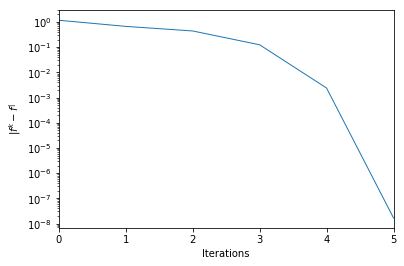

In [48]:
nsteps = history.shape[0]
    
plt.figure()
plt.autoscale(enable=True, axis='x', tight=True)
plt.semilogy(np.arange(0, nsteps), history, linewidth=1)
plt.xlabel('Iterations')
plt.ylabel(r'$|f^k - f^|$')
plt.show()

## Catenary Equation
---
#### System of Nonlinear Equations f

In [49]:
def fun(u, left = 2, right = 3, N = 100, c = 0.5):
    h = 5. / 100
    l = np.append(left, u[:-1])
    r = np.append(u[1:], right)
    u1 = (-1/h**2)*(-l + 2*u - r)
    u2 = (1/(2*h))*(r - l)
    f = u1 - c*((1 + (u2)**2)**0.5)
    return f

#### Jacobian

In [50]:
def tridiag(a, b, c, k1 = -1, k2 = 0, k3 = 1):
    return np.diag(b, k2) + np.diag(a, k1) + np.diag(c, k3)

In [51]:
def fun_jacobian(u, left = 2, right = 3, N = 100, c = 0.5):
    h = 5 / 100
    
    u = np.append(left, u)
    u = np.append(u,right)
    
    d = -2 * np.ones(N) * (1/h**2)
    up = (1/h**2) + c*(u[2:-1]-u[:-3])/(4*(1+((u[2:-1]-u[:-3])/(2*h))**2)**0.5)
    lo = (1/h**2) - c*(u[3:]-u[1:-2])/(4*(1+((u[3:]-u[1:-2])/(2*h))**2)**0.5)
    
    j = tridiag(up, d, lo)
    return j

#### Newton Method

In [52]:
def backtrack_linesearch(func, v, xk,pk, t=1, alpha = 0.1, beta = 0.8):

    while(la.norm(func(xk+t*pk[0]))/2 > la.norm(func(xk))/2 + alpha*t*(v@pk[0])):
        t = t*beta
    return t

In [53]:
def newton_method(fun, jacobian, x0, to1 = 10**-6):
    x = x0
    history = np.array([x0])
    f = np.array(fun(x))
    while(la.norm(f) > to1):
        p = la.lstsq(jacobian(x), -f, rcond = None)
        t = backtrack_linesearch(fun,f , x, p)
        x = x  + t * p[0]
        history = np.vstack( (history, x) )
        f = np.array(fun(x))
        #print(la.norm(f))
    return history,x

In [54]:
u0 = np.ones(100)
history, ustar = newton_method(fun, fun_jacobian, u0)

(0, 5)

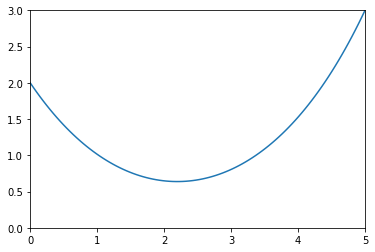

In [55]:
t = np.linspace(0, 5, 102)
u = np.append(2,ustar)
u = np.append(u,3)
plt.plot(t, u)
plt.ylim(0, 3)
plt.xlim(0,5)